## Liberías a utilizar

In [4]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd

In [7]:
# Parámetros fijos según Velasco-Hernández et al. 2015 (influenza)
gamma = 0.5    # incubación ≃ 2 días → γ = 1/2 = 0.5 d⁻¹
eta   = 0.25   # recuperación ≃ 4 días → η = 1/4 = 0.25 d⁻¹

## Funciones Modelo y Verosimilitud

In [10]:
# --------------------------------------------------
# 1. Modelo SEIR con forzamiento estacional
# --------------------------------------------------
def beta_t(t, beta0, alpha, phase=0):
    return beta0 * (1 + alpha * np.cos(2 * np.pi * (t + phase) / 365.0))

def modelo_seasonal(y, t, beta0, alpha, theta, N):
    S, E, I, R = y
    mu = MU_DIARIO
    β = beta_t(t, beta0, alpha)
    dSdt = mu*N - β*S*I/N - mu*S + theta*R
    dEdt = β*S*I/N - (mu + gamma)*E
    dIdt = gamma*E - (mu + eta)*I
    dRdt = eta*I - (mu + theta)*R
    return [dSdt, dEdt, dIdt, dRdt]
# --------------------------------------------------
# 2. Simulación de incidencia semanal
# --------------------------------------------------
def sim_incidence(beta0, alpha, theta, init, N, time_days, week_idx):
    sol = odeint(modelo_seasonal, init, time_days,
                 args=(beta0, alpha, theta, N))
    E = sol.T[1]
    daily_inc = gamma * E
    # Agregar por semanas:
    weekly_inc = np.array([
        daily_inc[time_days == (w*7)].sum()
        for w in week_idx
    ])
    return weekly_inc

# --------------------------------------------------
# 3. Log-verosimilitud sobre incidencia semanal
# --------------------------------------------------
def log_likelihood(data, pred, sigma):
    n = len(data)
    resid = data - pred
    return -0.5*(np.sum((resid/sigma)**2) + n*np.log(2*np.pi*sigma**2))


## MCMC

Utilizaremos Metroplosi Hasting, un método MCMC que propone nuevos valores de estimadores y decide si los acepta o rechaza.

In [11]:
# --------------------------------------------------
# 4. MH MCMC para (β₀, α, θ, σ_obs)
# --------------------------------------------------
def metropolis_hastings_seasonal(data, init_params, init_state,
                                 N, time_days, week_idx,
                                 proposal_scales, n_iter=10000):
    """
    Init_params = [beta0_0, alpha_0, theta_0, sigma_obs_0]
    """
    current = np.array(init_params, dtype=float)
    chain = np.zeros((n_iter, len(current)))
    log_post = np.zeros(n_iter)

    # Priori uniforme
    def log_prior(params):
        β0, α, θ, σ = params
        if not (0<β0<1 and 0<=α<=1 and 0<=θ<=0.1 and σ>0):
            return -np.inf
        return 0.0

    # Evaluación inicial
    lp0 = log_prior(current)
    pred0 = sim_incidence(*current[:3], init_state, N,
                          time_days, week_idx)
    ll0 = log_likelihood(data, pred0, current[3])
    current_lp = lp0 + ll0

    for i in range(n_iter):
        prop = current + np.random.normal(0, proposal_scales)
        lp = log_prior(prop)
        if lp > -np.inf:
            pred = sim_incidence(*prop[:3], init_state, N,
                                  time_days, week_idx)
            ll = log_likelihood(data, pred, prop[3])
            prop_lp = lp + ll
            if np.log(np.random.rand()) < (prop_lp - current_lp):
                current = prop
                current_lp = prop_lp

        chain[i] = current
        log_post[i] = current_lp

    return chain, log_post

In [14]:
df = pd.read_excel('influenza.xlsx')
df = df.sort_values(['Year', 'Epidemiological week']).reset_index(drop=True)

# índice de semana y tiempo en días
df['week_idx']  = np.arange(len(df))
df['time_days'] = df['week_idx'] * 7

# observaciones de incidencia semanal
incidence_obs = df['Influenza'].values
time_days     = df['time_days'].values
week_idx      = df['week_idx'].values

# población total (ajusta según SLP 2003-2009)
N = 2_500_000  

# condición inicial [S0, E0, I0, R0]
#   I0: casos de la primera semana (o un pequeño valor)
I0 = incidence_obs[0]
E0 = I0 * 2           # suposición: dos veces incubando
R0 = 0
S0 = N - (E0 + I0 + R0)
init_state = [S0, E0, I0, R0]

# 2. Parámetros iniciales y escalas de propuesta
# estimamos [beta0, alpha, theta, sigma_obs]
init_params    = [0.3, 0.2, 0.01, 50.0]
proposal_scales = [0.05, 0.02, 0.005, 5.0]

# 3. Ejecutar MCMC
chain, log_post = metropolis_hastings_seasonal(
    data        = incidence_obs,
    init_params = init_params,
    init_state  = init_state,
    N           = N,
    time_days   = time_days,
    week_idx    = week_idx,
    proposal_scales = proposal_scales,
    n_iter      = 20000
)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


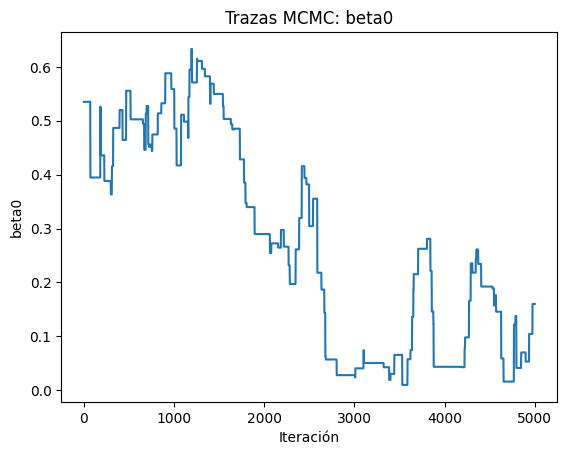

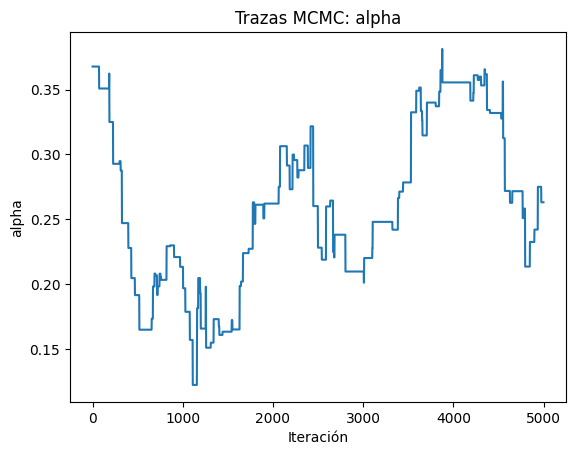

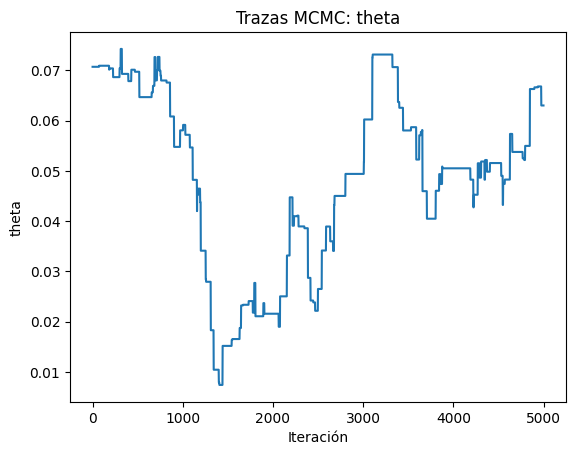

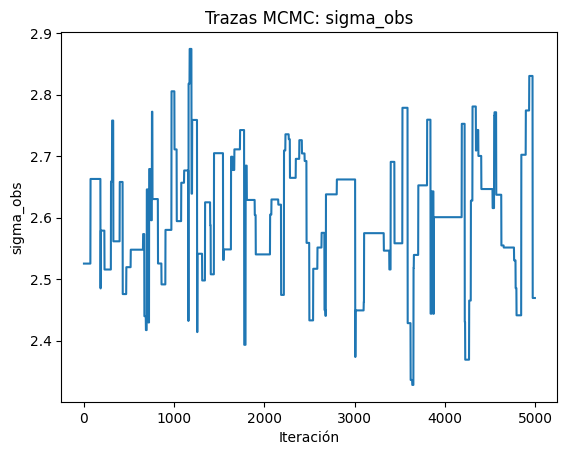

In [15]:
# 4. Revisa resultados
# Por ejemplo, los últimos 100 valores de cada parámetro:
import matplotlib.pyplot as plt

labels = ['beta0', 'alpha', 'theta', 'sigma_obs']
for i in range(chain.shape[1]):
    plt.figure()
    plt.plot(chain[-5000:, i])
    plt.title(f'Trazas MCMC: {labels[i]}')
    plt.xlabel('Iteración')
    plt.ylabel(labels[i])
    plt.show()